In [2]:
%load_ext autoreload
%autoreloAngleMSELossad 2

In [3]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

In [45]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
casp_protein_id = 'T1027'   # 6ya2
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']

da = DihedralAdherence(proteins[6], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
# da.test_pdbmine_conn()
# da.compute_structures(replace=False)
# da.query_pdbmine()

# da.load_results()
# da.compute_das(replace=True)
da.load_results_da()
results = pd.concat([q.results for q in da.queries])
print(results.groupby('phi').size().sort_index(ascending=False).head())
results.describe().loc[['min','max'], ['phi','psi']]
# print(da.xray_phi_psi.describe().loc[['min','max'], ['phi','psi']])
# da.phi_psi_predictions.describe().loc[['min','max'], ['phi','psi']]
# da.plot_da_for_seq('YGWPVCY')
# both = da.plot_res_vs_da(pred_id=da.alphafold_id)
# da.plot_heatmap()
# da.plot_da_vs_rmsd_simple()
# print(da.grouped_preds[da.grouped_preds.protein_id==da.get_id('337_5')].RMS_CA)
# rmsds, n, rmsd_inner = da.split_and_compute_rmsd(pred_id=da.get_id('337_5'), split=[(298, 311), (327,340)])

Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
phi
360.0     4
180.0     4
179.9    14
179.8    11
179.7     8
dtype: int64


,phi,psi
min,-180.0,-180.0
max,360.0,360.0


Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Highest DA Differences:

|   pos |   pos_xray | seq_ctxt   |   da_pred |   da_xray |   da_diff |
|------:|-----------:|:-----------|----------:|----------:|----------:|
|   235 |        228 | QFDNFLP    |   78.3976 |  43.1226  |   35.2749 |
|   234 |        227 | MQFDNFL    |   48.4814 |  13.3602  |   35.1212 |
|   185 |        185 | TTFVMTE    |   38.7485 |   3.64638 |   35.1021 |
|   163 |        163 | FRPAFEA    |   85.936  |  56.7159  |   29.2201 |
|   374 |        361 | SPMIKAI    |   46.7335 |  22.2084  |   24.5251 |
|   232 |        225 | IIMQFDN    |   34.064  |  10.3752  |   23.6888 |
|   184 |        184 | LTTFVMT    |   49.3908 |  28.1308  |   21.26   |
|   287 |        274 | KDWSHQK    |   73.75   |  56.1305  |   17.6195 |
|   307 |        294 | IFSFLTT    |   23.3419 |   6.10377 |   17.2381 |
|   128 |        128 | IIDASNA    |   18.5715 |   3.25119 |   15.3203 |


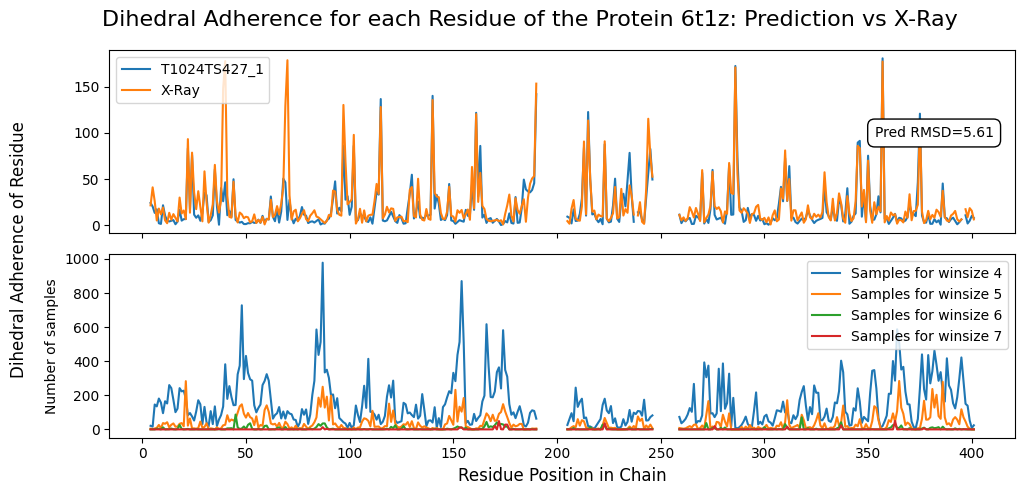

In [135]:
def plot_res_vs_da(ins, pred_id):
    # Plot xray vs prediction da for each residue of one prediction
    pred_name = pred_id
    pred = ins.phi_psi_predictions.loc[ins.phi_psi_predictions.protein_id == pred_id]
    pred = pred.drop_duplicates(subset=['seq_ctxt']) # for plotting only
    xray = ins.xray_phi_psi[['pos', 'seq_ctxt', 'da']]
    xray = xray.drop_duplicates(subset=['seq_ctxt']) # for plotting only

    both = pd.merge(pred, xray, how='inner', on=['seq_ctxt','seq_ctxt'], suffixes=('_pred','_xray'))
    both['da_diff'] = both['da_pred'] - both['da_xray']
    both = both.rename(columns={'pos_pred':'pos'})
    # Add na rows for missing residues
    pos = np.arange(both.pos.min(), both.pos.max(), 1)
    both = both.set_index('pos').reindex(pos).reset_index()
    # n_samples = np.array([([int(s) for s in l[1:-1].split(',')] if l else np.nan) for l in both.n_samples_list])
    n_samples = np.array([([int(s) for s in l[1:-1].split(',')] if l is not np.nan else [np.nan]*len(da.winsizes)) for l in both.n_samples_list.values])
    # print(both.shape, n_samples.shape)

    # Print highest values
    print('Highest DA Differences:\n')
    print(both.sort_values('da_diff', ascending=False).head(10)[
        ['pos', 'pos_xray', 'seq_ctxt','da_pred','da_xray','da_diff']
    ].to_markdown(index=False))

    fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
    # sns.lineplot(data=both, x='pos', y='da_pred', ax=axes[0], label=pred_name)
    # sns.lineplot(data=both, x='pos', y='da_xray', ax=axes[0], label='X-Ray')
    axes[0].plot(both.pos, both.da_pred, label=pred_name)
    axes[0].plot(both.pos, both.da_xray, label='X-Ray')
    axes[0].set_ylabel('')
    axes[0].legend()

    # sns.lineplot(data=both, x='pos', y='da_diff', ax=axes[1], label=f'Difference:\n{pred_name} - Xray')
    axes[1].plot(both.pos, n_samples.T[0] // 16, label=f'Samples for winsize {ins.winsizes[0]}')
    axes[1].plot(both.pos, n_samples.T[1] // 4, label=f'Samples for winsize {ins.winsizes[1]}')
    axes[1].plot(both.pos, n_samples.T[2] // 2, label=f'Samples for winsize {ins.winsizes[2]}')
    axes[1].plot(both.pos, n_samples.T[3], label=f'Samples for winsize {ins.winsizes[3]}')
    axes[1].set_ylabel('Number of samples')
    axes[1].set_xlabel('Residue Position in Chain', fontsize=12)
    axes[1].legend()

    xtext = 0.845 # 0.017
    fig.text(xtext, 1.70, f'Pred RMSD={ins.results.loc[ins.results.Model == pred_id, "RMS_CA"].values[0]:.02f}', 
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    fig.text(-0.02, 0.5, 'Dihedral Adherence of Residue', va='center', rotation='vertical', fontsize=12)
    fig.suptitle(f'Dihedral Adherence for each Residue of the Protein {ins.pdb_code}: Prediction vs X-Ray', fontsize=16)

    # for ax in axes:
    #     ax.axvspan(highlight[0], highlight[1], color='red', alpha=0.2)

    plt.tight_layout()
    plt.show()

    return both
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()
both = plot_res_vs_da(da, da.alphafold_id)
# plot_res_vs_da(da, da.protein_ids[0])

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
Initializing T1082 ...
Results already exist
Casp ID: T1082 	PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
Initializing T1058 ...
Results already exist
Casp ID: T1058 	PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
Initializing T1049 ...
Results already exist
Casp ID: T1049 	PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
Initializing T1056 ...
Results already exist
Casp ID: T1056 	PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
Initializing T1038 ...
Resul

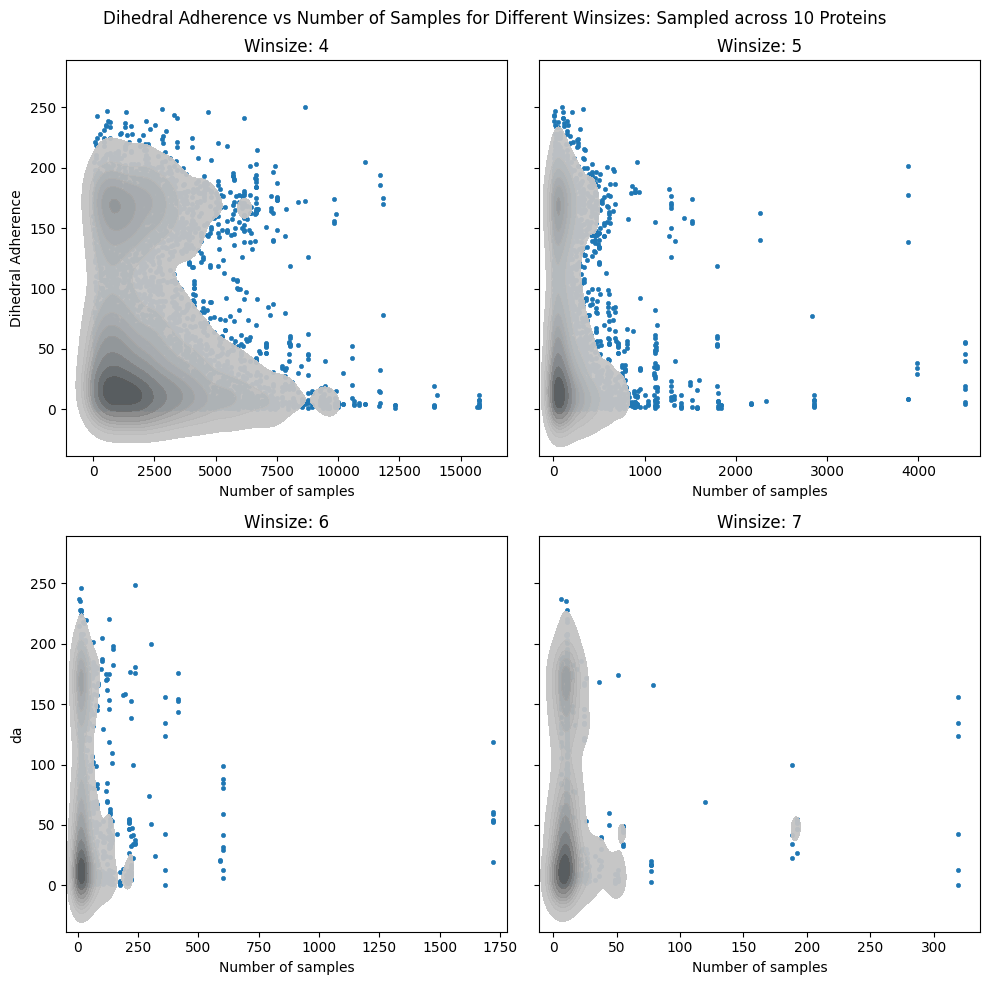

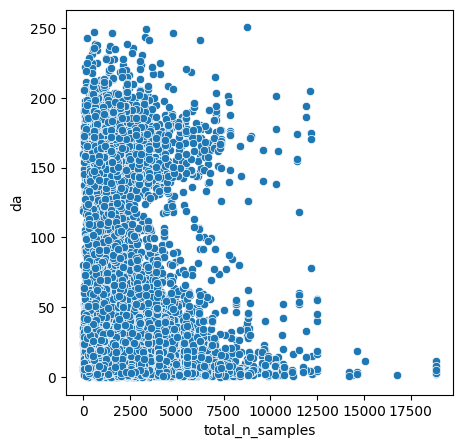

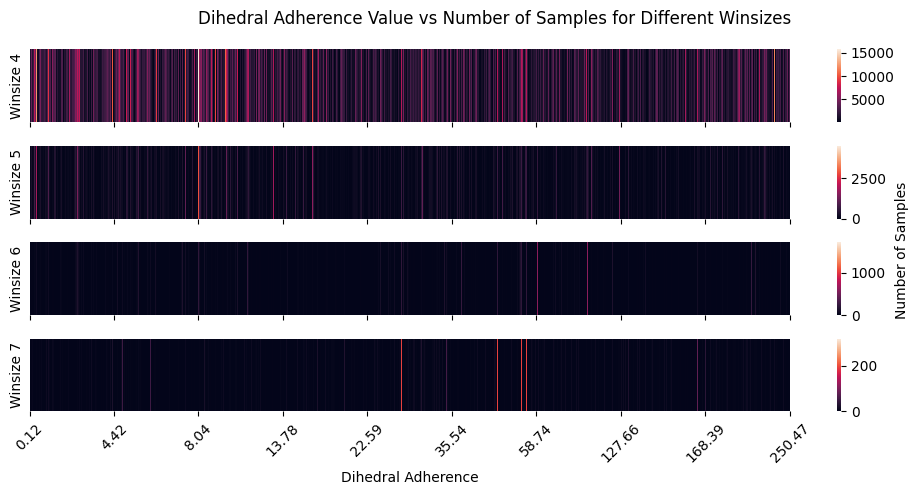

In [8]:
preds = []
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
for id in proteins:
    da = DihedralAdherence(id, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='kde_af')
    da.load_results_da()
    n_samples = np.array([([int(s) for s in l[1:-1].split(',')] if l is not np.nan else [np.nan]*len(da.winsizes)) for l in da.phi_psi_predictions.n_samples_list.values])
    for winsize, samples in zip(da.winsizes, n_samples.T):
        da.phi_psi_predictions[f'n_samples_{winsize}'] = samples
    da.phi_psi_predictions['total_n_samples'] = n_samples.sum(axis=1)
    preds.append(da.phi_psi_predictions.sample(min(1000, da.phi_psi_predictions.shape[0])))
    # preds.append(da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.get_id('460_2')])
preds = pd.concat(preds).reset_index(drop=True)
print(preds.shape)
# q = [.75,0.8,0.9,1]
q=[1,1,1,1]
fig, axes = plt.subplots(2,2, figsize=(10,10), sharey=True)
for i, winsize in enumerate(da.winsizes):
    ax = axes[i//2, i%2]
    # print(preds[f'n_samples_{winsize}'].quantile(q[i]))
    df = preds[preds[f'n_samples_{winsize}'] <= preds[f'n_samples_{winsize}'].quantile(q[i])]
    # df = df.sample(min(5000, df.shape[0]))
    print(winsize, df.shape)
    df = df[df[f'n_samples_{winsize}'] > 5]
    print(winsize, df.shape)
    sns.scatterplot(data=df, x=f'n_samples_{winsize}', y='da', ax=ax, alpha=1, color='tab:blue', edgecolor=None, marker='.')
    sns.kdeplot(data=df, x=f'n_samples_{winsize}', y='da', ax=ax, bw_method=0.2, color='black', fill=True, alpha=0.95)
    ax.set_title(f'Winsize: {winsize}')
    if i == 0:
        ax.set_ylabel('Dihedral Adherence')
    ax.set_xlabel('Number of samples')
    # ax.set_xscale('log')
fig.suptitle('Dihedral Adherence vs Number of Samples for Different Winsizes: Sampled across 10 Proteins')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(data=preds, x='total_n_samples', y='da', ax=ax)

# HEatmap
df = preds.sort_values('da_no_scale')
for i,w in enumerate(da.winsizes):
    df = df[df[f'n_samples_{w}'] <= df[f'n_samples_{w}'].quantile(q[i])]
n_samples = df.loc[~df.da.isna(), ['da'] + [f'n_samples_{w}' for w in da.winsizes]].values.T
das = n_samples[0]
fig, axes = plt.subplots(4,1,figsize=(10, 5), sharex=True)
for i,row in enumerate(n_samples[1:]):
    sns.heatmap(row.reshape(1,-1), ax=axes[i])
    xticks = np.linspace(0, len(das)-1, 10, dtype=int)
    axes[i].set_xticks(xticks)
    axes[i].set_xticklabels([f'{d:0.2f}' for d in das[xticks]])
    axes[i].tick_params(axis='x', rotation=45)
    if i == len(n_samples) - 2:
        axes[i].set_xlabel('Dihedral Adherence')
    axes[i].set_ylabel(f'Winsize {da.winsizes[i]}')
    axes[i].set_yticks([])

fig.text(.9, 0.5, 'Number of Samples', va='center', rotation='vertical')
fig.suptitle('Dihedral Adherence Value vs Number of Samples for Different Winsizes')
plt.tight_layout()
plt.show()

# # scale
# df = preds.sort_values('da')
# for i,w in enumerate(da.winsizes):
#     df = df[df[f'n_samples_{w}'] < df[f'n_samples_{w}'].quantile(q[i])]
# n_samples = df.loc[~df.da.isna(), ['da'] + [f'n_samples_{w}' for w in da.winsizes]].values.T
# das = n_samples[0]
# fig, axes = plt.subplots(4,1,figsize=(10, 5), sharex=True)
# for i,row in enumerate(n_samples[1:]):
#     sns.heatmap(row.reshape(1,-1), ax=axes[i])
#     xticks = np.linspace(0, len(das)-1, 10, dtype=int)
#     axes[i].set_xticks(xticks)
#     axes[i].set_xticklabels([f'{d:0.2f}' for d in das[xticks]])
#     axes[i].tick_params(axis='x', rotation=45)
#     if i == len(n_samples) - 2:
#         axes[i].set_xlabel('Dihedral Adherence')
#     axes[i].set_ylabel(f'Winsize {da.winsizes[i]}')
#     axes[i].set_yticks([])

#     # cbar = axes[i].collections[0].colorbar
#     # cbar.set_label('Number of Samples')
# fig.text(.9, 0.5, 'Number of Samples', va='center', rotation='vertical')
# fig.suptitle('Dihedral Adherence Value vs Number of Samples for Different Winsizes')
# plt.tight_layout()
# fig, axes = plt.subplots(2,2, figsize=(10,10), sharey=True)
# for i, winsize in enumerate(da.winsizes):
#     ax = axes[i//2, i%2]
#     sns.kdeplot(data=preds[preds[f'n_samples_{winsize}'] < preds[f'n_samples_{winsize}'].quantile(.8)], x=f'n_samples_{winsize}', y='da', ax=ax, bw_method=0.1, fill=True)
#     ax.set_title(f'Winsize: {winsize}')
#     ax.set_xlabel('Number of samples')
#     ax.set_ylabel('Dihedral Adherence')
#     # ax.set_xscale('log')
# plt.tight_layout()
# plt.show()

In [3]:
for casp_id in ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']:
    try:
        da = DihedralAdherence(casp_id, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], mode='kde_af')
        # da.query_pdbmine()
        # da.compute_structures(replace=False)
        da.load_results()
        da.compute_das(replace=True)
    except Exception as e:
        print(f"{casp_id} - Error: {e}")

Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
0/393: GKEFWNL
	Win 4: EFWN - 201 samples
	Win 5: KEFWN - 56 samples
	Win 6: KEFWNL - 0 samples
	Win 7: GKEFWNL - 0 samples
	Weighted n samples: 537.0
	0 predictions
No predictions seq GKEFWNL
1/393: KEFWNLD
	Win 4: FWNL - 350 samples
	Win 5: EFWNL - 19 samples
	Win 6: EFWNLD - 0 samples
	Win 7: KEFWNLD - 0 samples
	Weighted n samples: 464.0
	484 predictions
2/393: EFWNLDK
	Win 4: WNLD - 260 samples
	Win 5: FWNLD - 8 samples
	Win 6: FWNLDK - 0 samples
	Win 7: EFWNLDK - 0 samples
	Weighted n samples: 308.0
	484 predictions
3/393: FWNLDKN
	Win 4: NLDK - 2339 samples
	Win 5: WNLDK - 23 samples
	Win 6: WNLDKN - 0 samples
	Win 7: FWNLDKN - 0 samples
	Weighted n samples: 2477.0
	484 predictions
4/393: WNLDKNL
	Win 4: LDKN - 2174 samples
	Win 5: NLDKN - 39 samples
	Win 6: NLDKNL - 8 samples
	Win 7: WNLDKNL - 0 samples
	Weighted n samples: 2464.0
	484 predictions
5/393: NLDKNLQ
	Win 4: DKNL - 2907 samples
	Win

In [ ]:
from lib.fit_model_on_multiple import fit_lr, plot_md_vs_rmsd
import os
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

# model, grouped_preds = fit_model_on_multiple(['T1056', 'T1038', 'T1025', 'T1028'], WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, n_comp=2000)
model, grouped_preds = fit_lr(
    ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025'],
    # ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028'],
    [4,5,6,7], [1,32,64,128],
    PDBMINE_URL, PROJECT_DIR,
    n_comp=2000,
)
plot_md_vs_rmsd(grouped_preds, axlims=((0,60), (0,80)))